## Fogland Point, RI 
### MODFLOW, ~~SWI2~~, Flopy
### This notebook has been tested in an ubuntu-xenial based linux distro

-Spencer Harris  
-spharris@sas.upenn.edu

This model simulates transient movement of the freshwater-seawater interface beneath Fogland Point, a peninsula in the Narragansett Bay, Rhode Island. in response to recharge and groundwater withdrawals. One XX-ft thick aquifer that extends below sea level. The aquifer is unconfined, storage changes are not considered (all MODFLOW stress periods are steady-state).

The domain is discretized into 100 columns, 100 rows, and 2 layers, with respective cell dimensions of 25 ft (`DELR`), 25 ft (`DELC`), and XX. A total of 230 years is simulated using three stress periods with lengths of 200, 12, and 18 years, with constant time steps of 0.2, 0.1, and 0.1 years, respectively. 

The horizontal and vertical hydraulic conductivity of the fractured rock aquifer is 10$^{-7}$ ft/d and 10$^{-8}$ ft/d**?**, respectively. The effective porosity is 0.0015. The model is extended offshore along all sides and the ocean boundary is represented as a general head boundary condition (GHB). A freshwater head of (Bay depth\* -0.025) ft is specified for the Bay in all general head boundaries. The GHB conductance that controls outflow from the aquifer into the ocean is 15.6 ft$^{2}$/d and corresponds to a leakance of 0.025 d$^{-1}$ (or a resistance of 40 days).**may change?**

The groundwater is divided into a freshwater zone and a seawater zone, separated by an active ZETA surface between the zones (`NSRF=1`) that approximates the 50-percent seawater salinity contour. Fluid density is represented using the stratified density option (`ISTRAT=1`). The dimensionless density difference ($\nu$) between freshwater and saltwater is 0.025. The tip and toe tracking parameters are a `TOESLOPE` and `TIPSLOPE` of 0.1, a default `ALPHA` of 0.1, and a default `BETA` of 0.1. Initially, the interface between freshwater and saltwater is 1 m below MSL (0ft) on the island and at the top of the upper aquifer offshore. The SWI2 `ISOURCE` parameter is set to -2 in cells having GHBs so that water that infiltrates into the aquifer from the GHB cells is saltwater (zone 2), whereas water that flows out of the model at the GHB cells is identical to water at the top of the aquifer. ~~`ISOURCE` in layer X, row XX, column XX is set to 2 so that a saltwater well may be simulated in the third stress period of simulation 2.~~ In all other cells, the SWI2 `ISOURCE` parameter is set to 0, indicating boundary conditions have water that is identical to water at the top of the aquifer and can be either freshwater or saltwater, depending on the elevation of the active `ZETA` surface in the cell.

A constant recharge rate of 0.00479 feet per day (ft/d) is used in all three stress periods. The development of the freshwater lens is simulated for 200 years

-------------------------------------------------current stage-------------------------------------------------


, after which a pumping well having a withdrawal rate of XXX ft$^3$/d is started in layer X, row XX, column XX. For the first simulation (simulation 1), the well pumps for XX years, after which the interface almost reaches the top of the upper aquifer layer. In the second simulation (simulation 2), an additional well withdrawing
saltwater at a rate of 25 m$^3$/d is simulated below the freshwater well in layer 2 , row 31, column 36, 12 years after the freshwater groundwater withdrawal begins in the well in layer 1. The saltwater well is intended to prevent the interface from
upconing into the upper aquifer (model layer).

### Based off the Flopy notebook of SWI2 Example 4. Upconing Below a Pumping Well in a Two-Aquifer Island System in the [SWI2 documentation] (http://pubs.usgs.gov/tm/6a46/) 


Import `numpy` and `matplotlib`, set all figures to be inline, import `flopy.modflow` and `flopy.utils`.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
import os
import platform
import shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy


from flopy.utils.reference import SpatialReference
import flopy.utils.binaryfile as bf
#from flopy.utils.postprocessing import get_transmissivities, get_water_table, get_gradients, get_saturated_thickness

fm = flopy.modflow

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))
print('operating system: {}'.format(platform.system()))

3.6.2 |Continuum Analytics, Inc.| (default, Jul 20 2017, 13:51:32) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
numpy version: 1.13.1
matplotlib version: 2.0.2
flopy version: 3.2.6
operating system: Linux


Define model name of your model and the location of MODFLOW executable. All MODFLOW files and output will be stored in the subdirectory defined by the workspace. Create a model named `ml` and specify that this is a MODFLOW-2005 model.

#### Little extra work to make sure we've tracked down the executable

In [2]:
if platform.system() == 'Linux':
    exe_name = os.path.join("..", "..", "bin", "mf2005.nix") # adds path to mf2005.nix, which will be our executeable, to mfexe
    abspath = os.path.abspath(exe_name) # assigns absolute path of mfexe to abspath, double checking
    print(exe_name) #printing the variables
    print(abspath)
    print('if this =>  \"', os.path.isfile(exe_name),'\"  prints true, that means executable is in the correct spot')

../../bin/mf2005.nix
/home/sbhgeo/Documents/Fogland/bin/mf2005.nix
if this =>  " True "  prints true, that means executable is in the correct spot


In [3]:
#Set name of MODFLOW exe
#  assumes executable is in users path statement

if platform.system() == 'Linux':
    exe_name = abspath

if platform.system() == 'Windows':
    exe_name = 'mf2005.exe'

workspace = os.path.join('data')
#make sure workspace directory exists
if not os.path.exists(workspace):
    os.makedirs(workspace)
    
outpath = 'data'
if os.path.isdir(outpath):
    shutil.rmtree(outpath)
os.mkdir(outpath)

Define the number of layers, rows and columns. The heads are computed quasi-steady state (hence a steady MODFLOW run) while the interface will move. There are three stress periods with a length of 200, 12, and 18 years and 1,000, 120, and 180 steps. 

In [4]:

nrow, ncol = 100, 100
xll, yll = 403877, 172913 # origin of the model (lower left corner)
#xul, yul = 406377, 175413 # origin of model (upper left corner)
dxdy = 25 # grid spacing (in model units)
rot = 0 # rotation (positive counterclockwise)

# epsg code specifying coordinate reference system
# (https://www.epsg-registry.org/)
# in this case, UTM zone 16 N, NAD83
# http://spatialreference.org/ref/epsg/nad83-utm-zone-16n/
model_epsg = 3654

# alternatively, a proj4 string can be supplied
model_proj4 = 'http://spatialreference.org/ref/epsg/nad83-utm-zone-16n/proj4/'

# row and column spacings
# (note that delc is column spacings along a row; delr the row spacings along a column)
delc = np.ones(nrow, dtype=float) * dxdy
delr = np.ones(ncol, dtype=float) * dxdy


sr = SpatialReference(delr=delr, delc=delc, xll=xll, yll=yll, rotation=rot, epsg=model_epsg, units = 'feet', lenuni = 1)
#sr = SpatialReference(delr=delr, delc=delc, xul=xul, yul=yul, rotation=rot, epsg=model_epsg, units = 'feet', lenuni = 1)

print(sr.bounds)
print(sr)

(403877.0, 172913.0, 406377.0, 175413.0)
xul:403877; yul:175413; rotation:0; proj4_str:+proj=tmerc +lat_0=41.08333333333334 +lon_0=-71.5 +k=0.99999375 +x_0=99999.99998983997 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +to_meter=0.3048006096012192 +no_defs ; units:feet; lenuni:1; length_multiplier:1.0


In [5]:
print('DELR =', delr[0])
print('DELC =', delc[0])

DELR = 25.0
DELC = 25.0


In [6]:
sr

xul:403877; yul:175413; rotation:0; proj4_str:+proj=tmerc +lat_0=41.08333333333334 +lon_0=-71.5 +k=0.99999375 +x_0=99999.99998983997 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +to_meter=0.3048006096012192 +no_defs ; units:feet; lenuni:1; length_multiplier:1.0

Grid bounds

In [7]:
sr.bounds

(403877.0, 172913.0, 406377.0, 175413.0)

----------------
Define the `DIS` package

In [8]:
# nlay = 2
# nper = 3
# perlen = [365.25 * 200., 365.25 * 12., 365.25 * 18.]
# nstp = [1000, 120, 180]
# save_head = [200, 60, 60] # what is this for?
# steady = True

nlay = 3
nper = 1
perlen = [365.25 * 200.]
nstp = [1000] # timesteps of 73.05 days; 0.2 yrs
save_head = [50] # what is this for?
steady = True

Import Elevation CSV, (created in QGIS) for top of layer 1 with sea level as 0 feet

In [9]:
lay1top = np.loadtxt('./importdata/lay1top.csv', delimiter=',', skiprows=1)
lay1top = lay1top[:,6]
lay1top = lay1top.reshape(100,100)

lay1topfud = np.flipud(lay1top) 
lay1topflr = np.fliplr(lay1top)
lay1topreversed = np.fliplr(lay1topfud)
#new line flipping array because CSV was made with grid origin in upper left instead of lowerleft

print(lay1topfud.shape, type(lay1topfud))

(100, 100) <class 'numpy.ndarray'>


In [10]:
# dis data
top = lay1topfud
botm = np.array([-43., -90., -200.])

Define the `IBOUND` array and starting heads for the `BAS` package. The corners of the model are defined to be inactive.

In [11]:
# bas data
# ibound - active except for the corners
ibound = np.ones((nlay, nrow, ncol), dtype= np.int)
ibound[:, 0, 0] = 0
ibound[:, 0, -1] = 0
ibound[:, -1, 0] = 0
ibound[:, -1, -1] = 0
# initial head data
ihead = np.zeros((nlay, nrow, ncol), dtype=np.float)
ihead.shape

(3, 100, 100)

Define the layers to be confined and define the horizontal and vertical hydraulic conductivity of the aquifer for the `LPF` package.

In [12]:
# lpf data
#laytyp = np.array([1,0])
#laytyp = np.array([0,0])
laytyp = np.array([1,1,1]) #lay1, 2, 3;unconfined, unconfined, unconfined

sy = 0.0001 # From Carleton 1999, Numerical model pg.27 of wrir 98-4126A
# sy is only read in for transient runs, when change in storage is calculated

hk = 1.975 #calculated from pump test at well 17 (1.975 ft/day)
vka = 0.1975 #calculated from pump test at well 17 (0.1975 ft/day)

#hk = 0.395 #factor of 5 less than calculated from pump test at well 17 (1.975 ft/day)
#vka = 0.0395 #factor of 5 less than calculated from pump test at well 17 (0.1975 ft/day)

#hk = 0.1975 #factor of 10 less than calculated from pump test at well 17
#vka = 0.01975 #factor of 10 less calculated from pump test at well 17


Define the boundary condition data for the model

Pulling in data in for GHB 

In [13]:
seawater_GHB = np.loadtxt('./importdata/bay_heads_GHB_ft.csv', delimiter=',', skiprows=1)
index = seawater_GHB[:,5]
index = index.reshape(100,100)

index = np.flipud(index) 
#new line flipping array because CSV was made with grid origin in upper left instead of lowerleft

print(index.shape, type(index))

seawater_heads = seawater_GHB[:,4]
seawater_heads= seawater_heads.reshape(100,100)
print(seawater_heads.shape, type(seawater_heads))

(100, 100) <class 'numpy.ndarray'>
(100, 100) <class 'numpy.ndarray'>


In [14]:
# boundary condition data
# ghb data
colcell, rowcell = np.meshgrid(np.arange(0, ncol), np.arange(0, nrow))
# making an grid of where GHB is active, 1 = active, 0 = inactive

nghb = int(np.sum(index))
lrchc = np.zeros((nghb, 5))
lrchc[:, 0] = 0
lrchc[:, 1] = rowcell[index == 1]
lrchc[:, 2] = colcell[index == 1]
lrchc[:, 3] = seawater_heads[index == 1]
lrchc[:, 4] = dxdy * dxdy / (vk/abs(botm[0])) # 217.86 #resistance time of 218 days = conductance of 2.87 ft2/day
# create ghb dictionary
ghb_data = {0:lrchc}

# recharge data
rch = np.zeros((nrow, ncol), dtype=np.float)
rch[index == 0] = 0.00479 #estimated as 1/2 of all precip (annual averaged) 
# need to recalculate recharge.....
# create recharge dictionary
rch_data = {0: rch}

# # well data

# nwells = 16
# lrcq = np.zeros((nwells, 4))
# lrcq[0, :] = np.array((0, 60, 32, 0)) #12 shallow well
# lrcq[1, :] = np.array((0, 58, 37, 0)) #15 shallow well
# lrcq[2, :] = np.array((1, 58, 42, 0)) #1 medium well
# lrcq[3, :] = np.array((1, 56, 42, 0)) #21 medium well
# lrcq[4, :] = np.array((1, 53, 35, 0)) #24 medium well
# lrcq[5, :] = np.array((1, 51, 37, 0)) #36 medium well
# lrcq[6, :] = np.array((1, 48, 47, 0)) #33 medium well
# lrcq[7, :] = np.array((1, 44, 35, 0)) #56 medium well
# lrcq[8, :] = np.array((1, 43, 37, 0)) #55 medium well
# lrcq[9, :] = np.array((0, 42, 39, 0)) #55a shallow well
# lrcq[10, :] = np.array((1, 42, 48, 0)) #65 medium well
# lrcq[11, :] = np.array((1, 39, 38, 0)) #64 medium well
# lrcq[12, :] = np.array((2, 37, 42, 0)) #77 deep well
# lrcq[13, :] = np.array((0, 36, 37, 0)) #78 shallow well
# lrcq[14, :] = np.array((1, 30, 46, 0)) #5 medium well
# lrcq[15, :] = np.array((1, 26, 40, 0)) #17 medium well




# lrcqw = lrcq.copy()
# lrcqw[:, 3] = -1.83 # 100 gal/day; 13.37 ft3/day for 50 days = 1.83 ft3/day mean annual widthdrawl
# lrcqw[7, 3] = 0 #no pumping well 56
# lrcqw[6, 3] = 0 #no pumping well 33
# lrcqw[12, 3] = -3.66 # well 77; 200 gal/day; 26.73 ft3/day for 50 days = 3.66 ft3/day mean annual widthdrawl
# lrcqw[11, 3] = -0.366 # well 77; 20 gal/day; 2.67 ft3/day for 50 days = 0.366 ft3/day mean annual widthdrawl

# base_well_data = {0:lrcqw}

In [29]:
# swi2 data
nadptmx = 10
nadptmn = 1
nu = [0, 0.025] #approximates 50% line
numult = 0.250
toeslope = nu[1] / numult  #0.1
tipslope = nu[1] / numult  #0.1
z1 = 0.0 * np.ones((nrow, ncol))
z1[index == 0] = -1 #not estimated via ghyben-herzberg
z = np.array([[z1,z1,z1]])
iso = np.zeros((nlay, nrow, ncol), dtype=np.int) #Sources and sinks have 
# the same fluid density as the active zone at the top of the aquifer
iso[0, :, :][index == 0] = 1 # Sources and sinks have the same fluid density 
#as the zone ISOURCE. If such a zone is not present in the cell,
#sources and sinks have the same fluid density as the active zone at the top of the aquifer.

iso[0, :, :][index == 1] = -2 # Sources have same fluid density as
#the zone with a number equal to the absolute value of ISOURCE. Sinks have the same fluid density as
# the active zone at the top of the aquifer.

ssz=0.1 
#ssz=0.0014 # borrowed from Carleton, Welty, and Buxton 1999
# swi2 observations
#obsnam = ['layer1_', 'layer2_']
#obslrc=[[0, 30, 35],[1,30,35], ]
#nobs = len(obsnam)
#iswiobs = 1051

In [30]:
iso.shape
z.shape
#type(z)

(1, 3, 100, 100)

Create output control (OC) data using words 

In [31]:
# oc data
# spd = {(0,199): ['print budget', 'save head'],
#        (0,200): [],
#        (0,399): ['print budget', 'save head'],
#        (0,400): [],
#        (0,599): ['print budget', 'save head'],
#        (0,600): [],
#        (0,799): ['print budget', 'save head'],
#        (0,800): [],
#        (0,999): ['print budget', 'save head'],
#        (1,0): [],
#        (1,59): ['print budget', 'save head'],
#        (1,60): [],
#        (1,119): ['print budget', 'save head'],
#        (1,120): [],
#        (2,0): [],
#        (2,59): ['print budget', 'save head'],
#        (2,60): [],
#        (2,119): ['print budget', 'save head'],
#        (2,120): [],
#        (2,179): ['print budget', 'save head']}

spd = {(0,99): ['print budget', 'save head'],
       (0,100): [],
       (0,199): ['print budget', 'save head'],
       (0,200): [],
       (0,299): ['print budget', 'save head'],
       (0,300): [],
       (0,399): ['print budget', 'save head'],
       (0,400): [],
       (0,499): ['print budget', 'save head'],
       (0,500): [],
       (0,599): ['print budget', 'save head'],
       (0,600): [],
       (0,699): ['print budget', 'save head'],
       (0,700): [],
       (0,799): ['print budget', 'save head'],
       (0,800): [],
       (0,899): ['print budget', 'save head'],
       (0,900): [],
       (0,999): ['print budget', 'save head']}

In [32]:
sr = SpatialReference(delr=delr, delc=delc, xll=xll, yll=yll, rotation=rot, epsg=model_epsg, units = 'feet', lenuni = 1)

Create the model with the freshwater well (Simulation 1)

In [33]:
modelname = 'swifogland_s1'
ml = flopy.modflow.Modflow(modelname, version='mf2005', exe_name=exe_name, model_ws=workspace)



discret = flopy.modflow.ModflowDis(ml, nlay=nlay, nrow=nrow, ncol=ncol, laycbd=0,
                                   delr=delr, delc=delc, top=lay1topfud, botm=botm,
                                   nper=nper, perlen=perlen, nstp=nstp, lenuni = 1, xul = 2500, yul = 2500)


bas = flopy.modflow.ModflowBas(ml, ibound=ibound, strt=ihead)
lpf = flopy.modflow.ModflowLpf(ml, laytyp=laytyp, hk=hk, vka=vka, sy=sy)
#wel = flopy.modflow.ModflowWel(ml, stress_period_data=base_well_data)
ghb = flopy.modflow.ModflowGhb(ml, stress_period_data=ghb_data)
rch = flopy.modflow.ModflowRch(ml, rech=rch_data)
swi = flopy.modflow.ModflowSwi2(ml, nsrf=1, istrat=1, toeslope=toeslope, tipslope=tipslope, nu=nu, 
                                alpha = 0.1, zeta=z, ssz=ssz, isource=iso, nsolver=2, nadptmx=nadptmx, nadptmn=nadptmn,
                                iswizt=55) 
oc = flopy.modflow.ModflowOc(ml, stress_period_data=spd)
pcg = flopy.modflow.ModflowPcg(ml, hclose=1.0e-6, rclose=3.0e-3, mxiter=100, iter1=50)

Look at the model

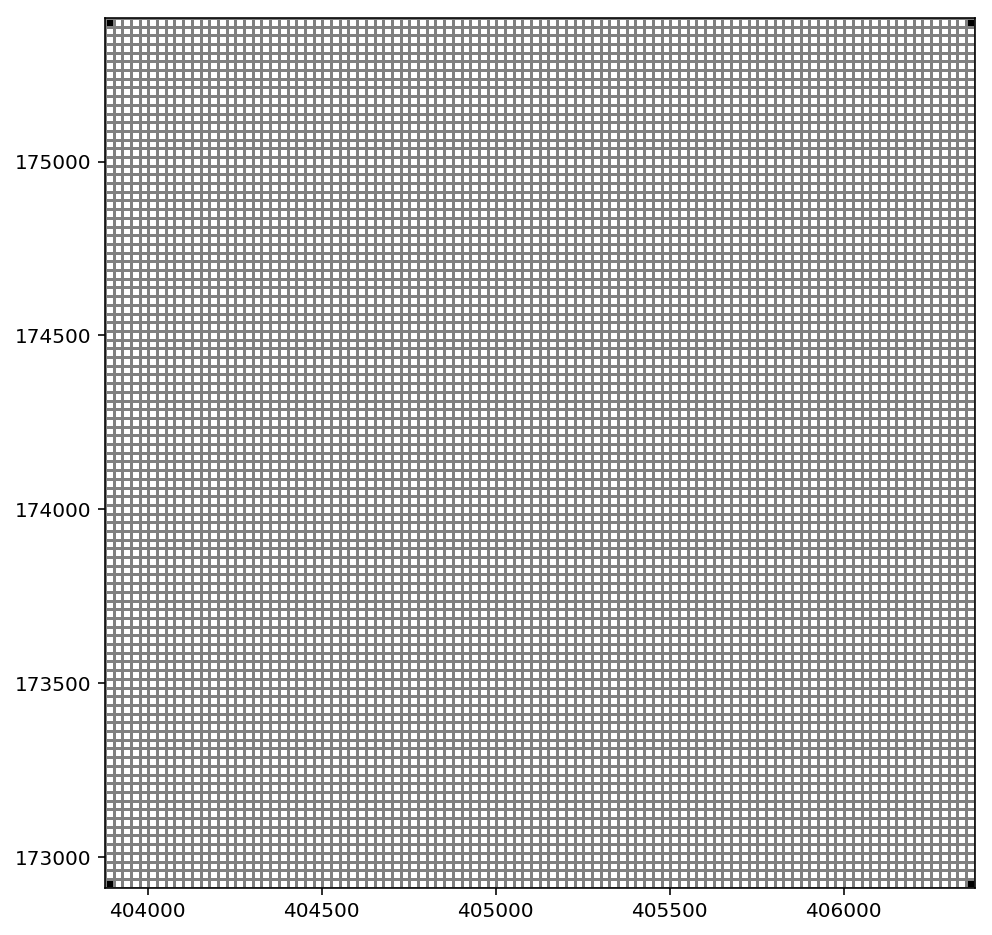

In [34]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(sr=sr, model=ml)
quadmesh = modelmap.plot_ibound()
linecollection = modelmap.plot_grid()

Write the simulation 1 MODFLOW input files and run the model

In [35]:
ml.sr = SpatialReference(delr=delr, delc=delc, xll=xll, yll=yll, rotation=rot, epsg=model_epsg, units = 'feet', lenuni = 1)


In [36]:
ml.write_input()

In [37]:
ml.sr

xul:403877; yul:175413; rotation:0; proj4_str:+proj=tmerc +lat_0=41.08333333333334 +lon_0=-71.5 +k=0.99999375 +x_0=99999.99998983997 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +to_meter=0.3048006096012192 +no_defs ; units:feet; lenuni:1; length_multiplier:1.0

In [38]:
ml.sr.bounds

(403877.0, 172913.0, 406377.0, 175413.0)

In [39]:
import timeit

In [40]:
start_time = timeit.default_timer()
print(ml.run_model(silent=True))
elapsed = timeit.default_timer() - start_time

(True, [])


In [41]:
print(elapsed)

153.94341679300123


Load the simulation 1 `ZETA` data and `ZETA` observations.

In [42]:
# read base model zeta
zfile = flopy.utils.CellBudgetFile(os.path.join(ml.model_ws, modelname+'.zta'))
kstpkper = zfile.get_kstpkper()
zeta = []
for kk in kstpkper:
    zeta.append(zfile.get_data(kstpkper=kk, text='ZETASRF  1')[0])
zeta = np.array(zeta)
# read swi obs
#zobs = np.genfromtxt(os.path.join(ml.model_ws, modelname+'.zobs.out'), names=True)

In [43]:
zeta.shape

(10, 3, 100, 100)

Create arrays for the x-coordinates and the output years

In [44]:
x = np.linspace(-1250, 1250, 100)
xcell = np.linspace(-1250, 1250, 100) + delr / 2.
xedge = np.linspace(-1225, 1225, 101)
years = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

Define figure dimensions and colors used for plotting `ZETA` surfaces

In [45]:
# figure dimensions
fwid, fhgt = 8.00, 5.50
flft, frgt, fbot, ftop = 0.125, 0.95, 0.125, 0.925

# line color definition
icolor = 10
colormap = plt.cm.jet  #winter
cc = []
cr = np.linspace(0.9, 0.0, icolor)
for idx in cr:
    cc.append(colormap(idx))

In [46]:
icolor

10

(-220, 10)

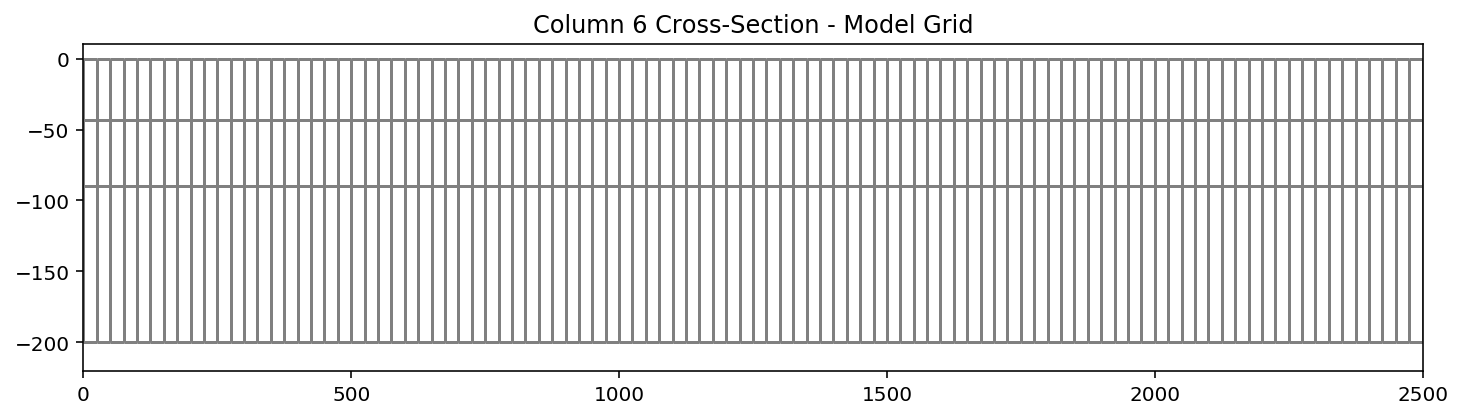

In [47]:
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the ModelCrossSection class
modelxsect = flopy.plot.ModelCrossSection(model=ml, line={'Column': 5})

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
linecollection = modelxsect.plot_grid()
t = ax.set_title('Column 6 Cross-Section - Model Grid')
ax.set_ylim(-220,10)

(-220, 10)

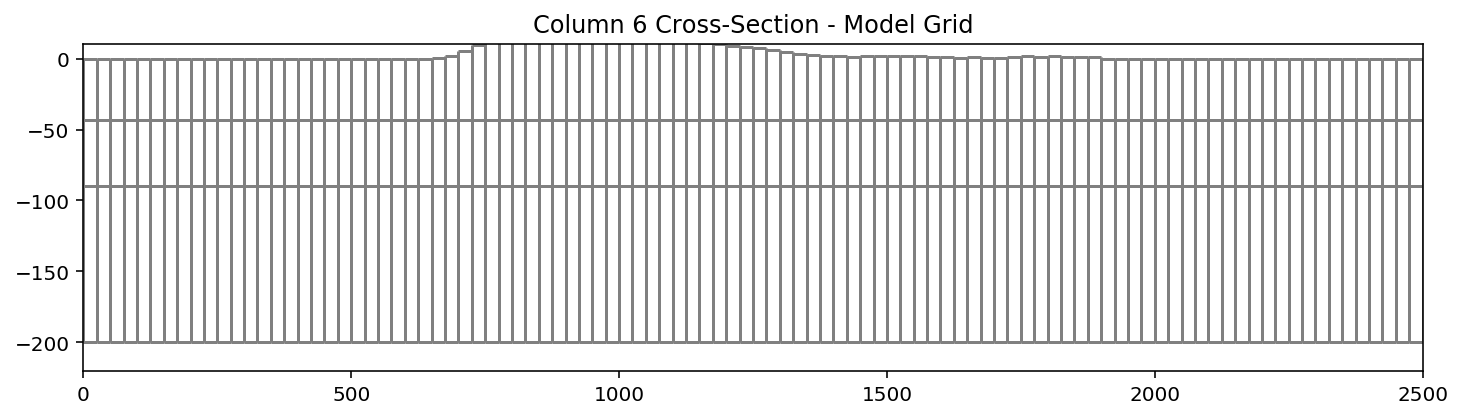

In [48]:
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the ModelCrossSection class
modelxsect = flopy.plot.ModelCrossSection(model=ml, line={'Row': 50})

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
linecollection = modelxsect.plot_grid()
t = ax.set_title('Column 6 Cross-Section - Model Grid')
ax.set_ylim(-220,10)

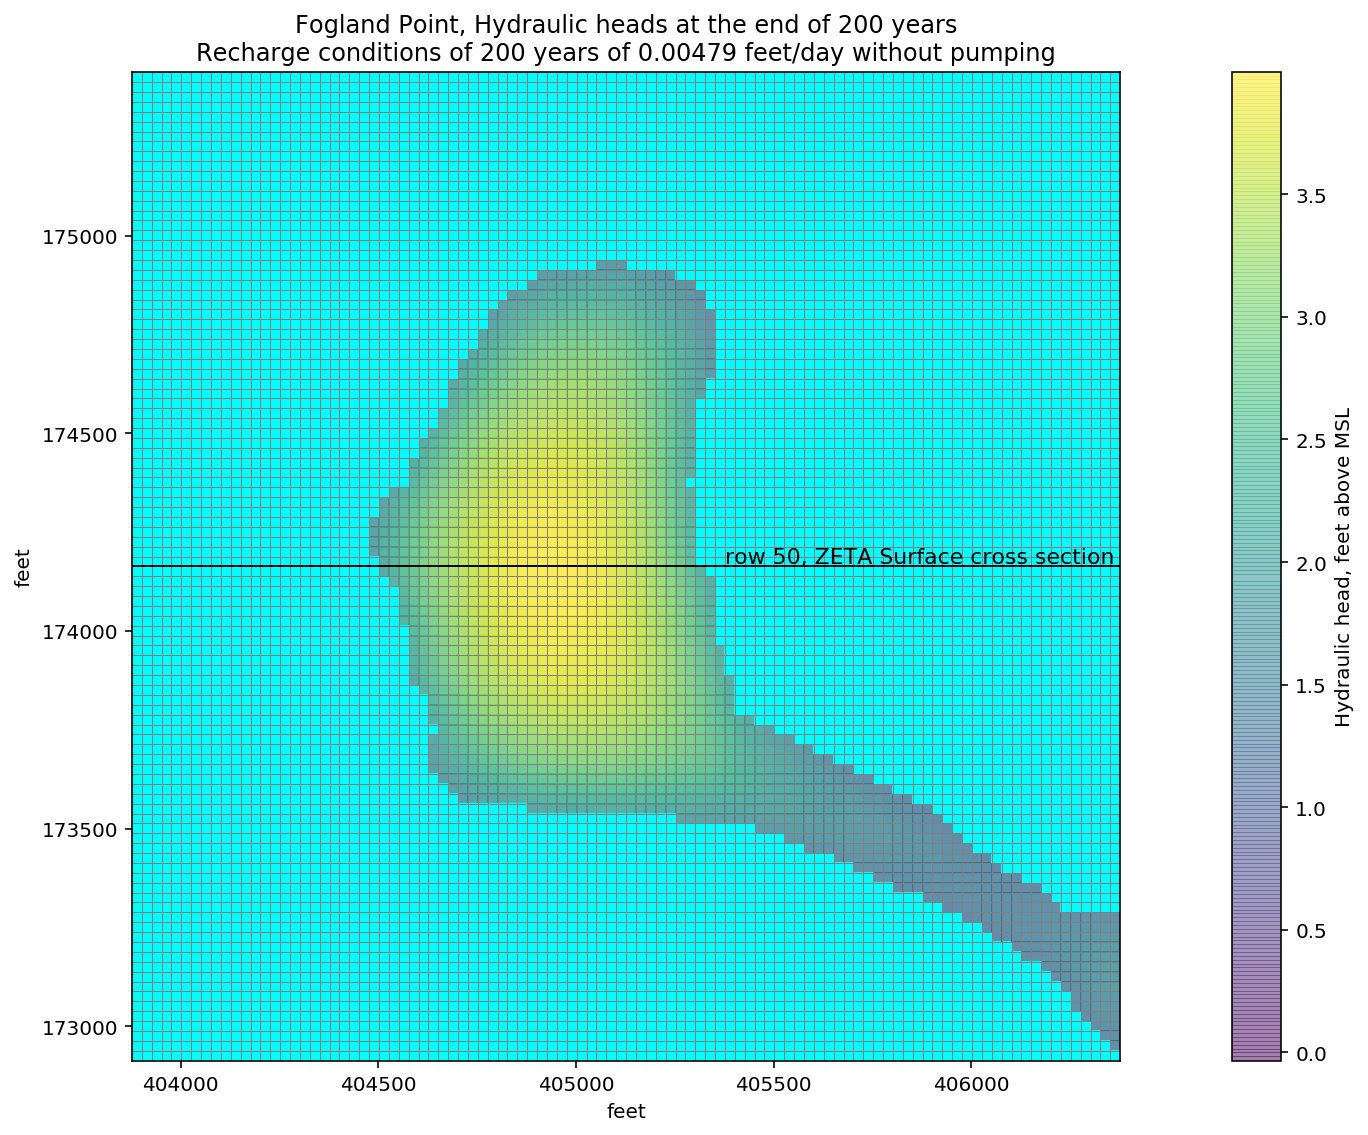

In [49]:
fname = os.path.join('./data/swifogland_s1.hds')
hdobj = flopy.utils.HeadFile(fname)
head = hdobj.get_data()
levels = np.arange(-5,10,.5)

fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(2, 1, 1, aspect='equal')
ax.set_title('Fogland Point, Hydraulic heads at the end of 200 years'
             '\nRecharge conditions of 200 years of 0.00479 feet/day without pumping')
modelmap = flopy.plot.ModelMap(model=ml)
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_array(head, masked_values=[999., -9.99989990e+02], alpha=0.5,)
modelmap.plot_bc("GHB")
linecollection = modelmap.plot_grid(linewidth=0.5)
cb = fig.colorbar(quadmesh, ax = ax)
cb.set_label('Hydraulic head, feet above MSL')
ax.plot([403877, 406377], [174163, 174163], color='k', linewidth=1.0)
ax.text(0.6, .52, 'row 50, ZETA Surface cross section', transform=ax.transAxes, va='top', ha='left', size='11')


ax.set_xlabel('feet')
ax.set_ylabel('feet')

# ax = fig.add_subplot(2, 1, 2, aspect='equal')
# ax.set_title('contour_array()')
# modelmap = flopy.plot.ModelMap(model=ml)
# quadmesh = modelmap.plot_ibound()
# #modelmap.plot_bc("WEL")
# contour_set = modelmap.contour_array(head, masked_values=[999., -9.99989990e+02], levels=levels)
# linecollection = modelmap.plot_grid()
# cb = fig.colorbar(quadmesh, ax = ax)


In [50]:
#levels
#head

Recreate **Figure 9** from the [SWI2 documentation](http://pubs.usgs.gov/tm/6a46/).  

A cross section showing results along the centerline of the island through the wells is shown in figure 9. The position of the interface is shown at 40-year increments for stress period 1, during development of the freshwater lens (fig. 9A). After 200 years, the interface approaches the steady-state position. The position of the interface for simulation 1 is shown at 6-year increments in figure 9B. In simulation 1, the interface
moves into the upper layer after approximately 14 years. The position of the interface for simulation 2 is shown at 6-year increments in figure 9C. During the first 12 years of groundwater withdrawals, the position of the interface is identical for simulations 1 and 2. After 12 years, the saltwater well begins pumping saltwater from the lower aquifer (model layer 2) and the progression of the upconing of the interface is reduced. The position of the interface in the aquifer over time is shown for simulations 1 and 2 in the cells containing the freshwater and saltwater wells (row 31, column 36) in figure 9D. Simulation results are identical during the first 12 years, because groundwater withdrawals are the same in both simulations. Addition of the saltwater well causes an initial decrease in the interface elevation and an eventual increase in the interface elevation, although the rate of upward movement of the interface is less in the simulation with both the freshwater and
saltwater wells than the simulation with only the freshwater well.

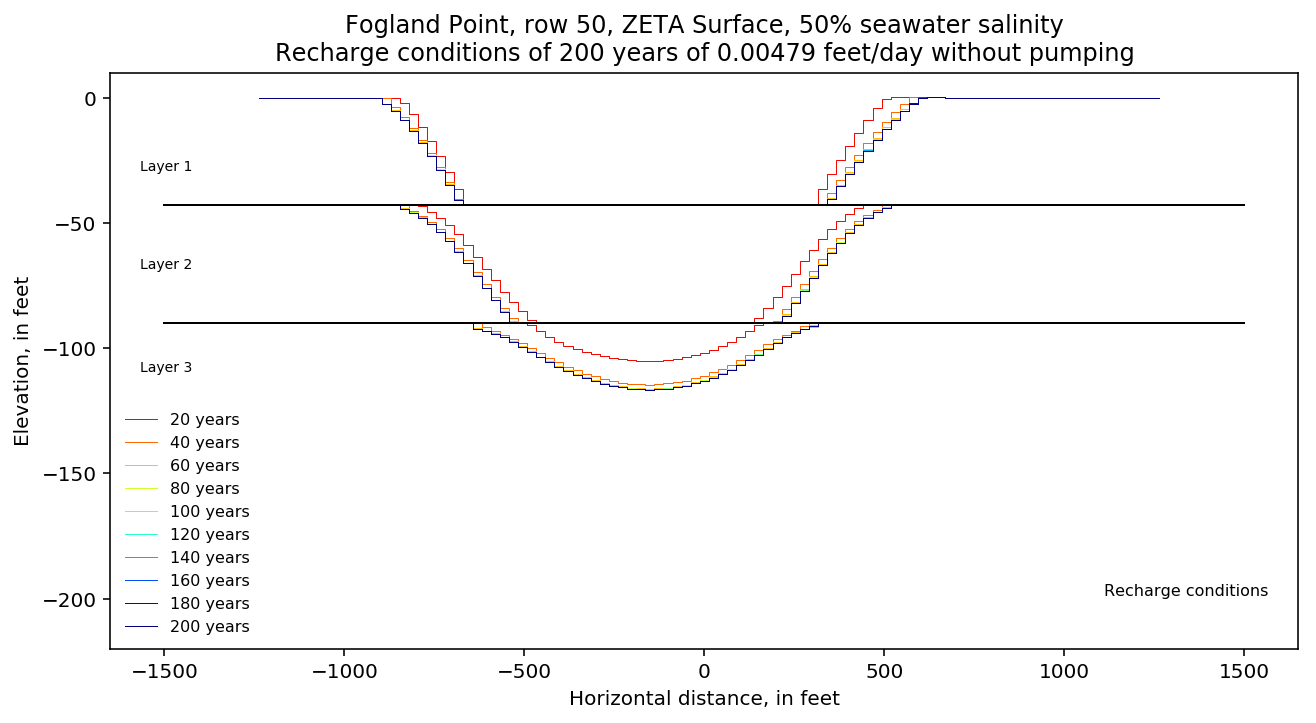

In [51]:
plt.rcParams.update({'legend.fontsize': 8, 'legend.frameon' : False})
#fig = plt.figure(figsize=(fwid, fhgt), facecolor='w')
fig = plt.figure(figsize=(10, 5), facecolor='w')
fig.subplots_adjust(wspace=0.25, hspace=0.25, left=flft, right=frgt, bottom=fbot, top=ftop)
# first plot
ax = fig.add_subplot(1,1,1)
# axes limits
#ax.set_xlim(-1500, 1500)
ax.set_ylim(-220, 10)
for idx in range(10):
    # layer 1
    ax.plot(xcell, zeta[idx, 0, 50, :], drawstyle='steps-mid', 
            linewidth=0.5, color=cc[idx], label='{:2d} years'.format(years[idx]))
    # layer 2
    ax.plot(xcell, zeta[idx, 1, 50, :], drawstyle='steps-mid',
            linewidth=0.5, color=cc[idx], label='_None')
    # layer 3
    ax.plot(xcell, zeta[idx, 2, 50, :], drawstyle='steps-mid',
            linewidth=0.5, color=cc[idx], label='_None')

ax.plot([-1500, 1500], [-43, -43], color='k', linewidth=1.0)
ax.plot([-1500, 1500], [-90, -90], color='k', linewidth=1.0)

# legend
plt.legend(loc='lower left')
# axes labels and text
ax.set_xlabel('Horizontal distance, in feet')
ax.set_ylabel('Elevation, in feet')
ax.text(0.025, .85, 'Layer 1', transform=ax.transAxes, va='top', ha='left', size='7')
ax.text(0.025, .68, 'Layer 2', transform=ax.transAxes, va='top', ha='left', size='7')
ax.text(0.025, .5, 'Layer 3', transform=ax.transAxes, va='top', ha='left', size='7')


ax.text(0.975, .1, 'Recharge conditions', transform=ax.transAxes, va='center', ha='right', size='8')
ax.set_title('Fogland Point, row 50, ZETA Surface, 50% seawater salinity'
             '\nRecharge conditions of 200 years of 0.00479 feet/day without pumping')

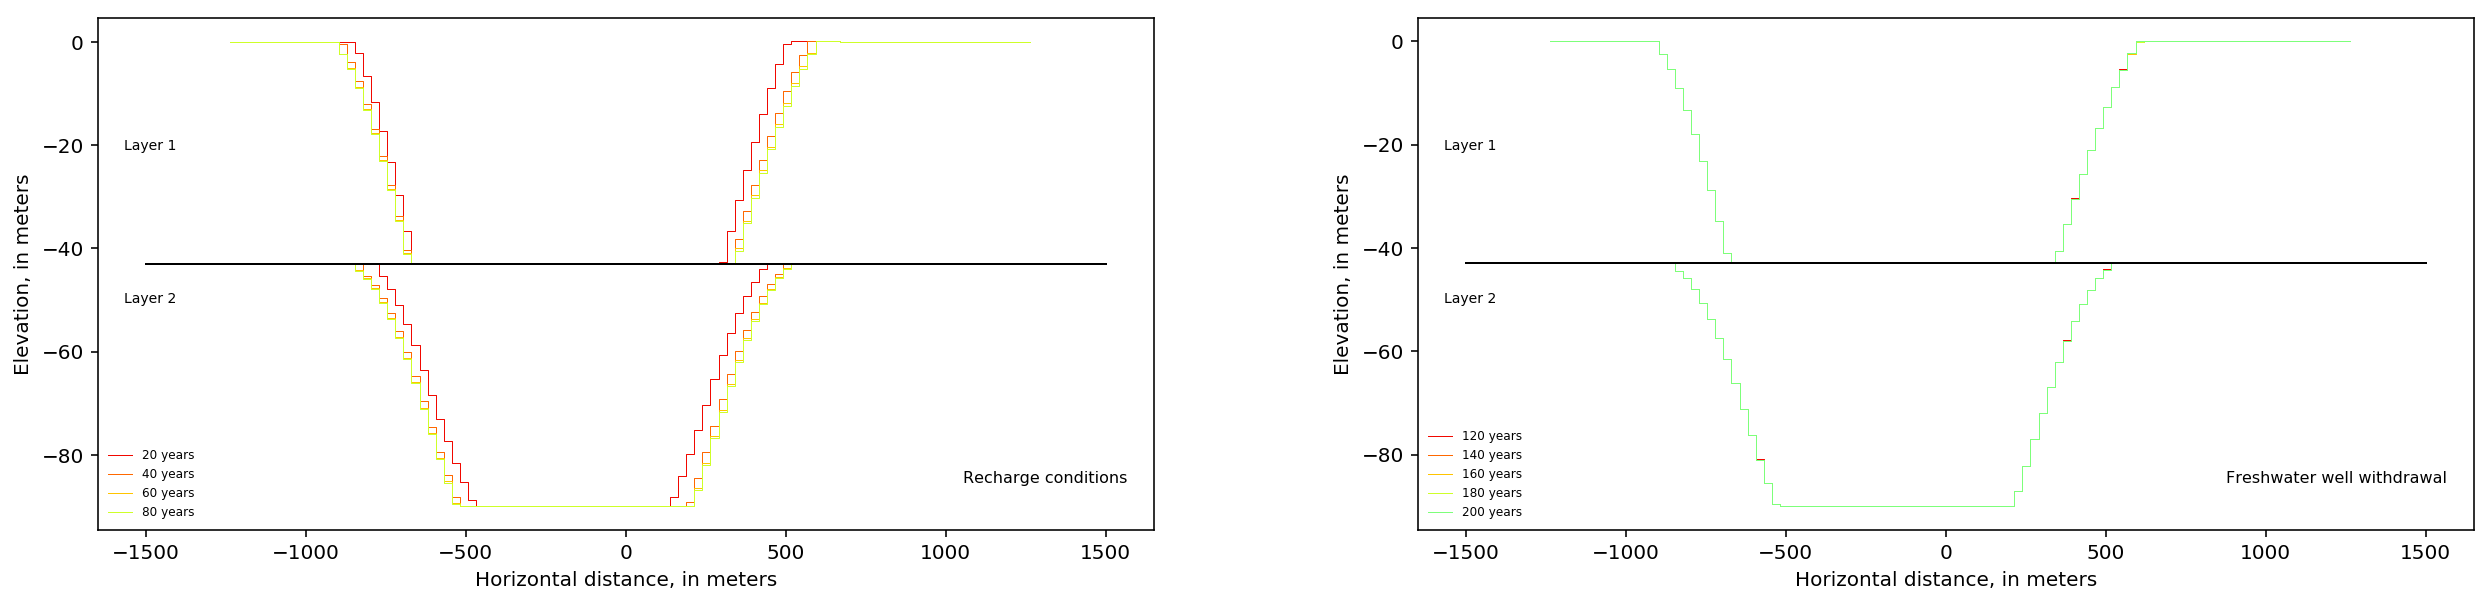

In [52]:
plt.rcParams.update({'legend.fontsize': 6, 'legend.frameon' : False})
#fig = plt.figure(figsize=(fwid, fhgt), facecolor='w')
fig = plt.figure(figsize=(20, 10), facecolor='w')
fig.subplots_adjust(wspace=0.25, hspace=0.25, left=flft, right=frgt, bottom=fbot, top=ftop)
fig
# first plot
ax = fig.add_subplot(2, 2, 1)
# axes limits
#ax.set_xlim(-1500, 1500)
#ax.set_ylim(-50, -10)
for idx in range(4):
    # layer 1
    ax.plot(xcell, zeta[idx, 0, 50, :], drawstyle='steps-mid', 
            linewidth=0.5, color=cc[idx], label='{:2d} years'.format(years[idx]))
    # layer 2
    ax.plot(xcell, zeta[idx, 1, 50, :], drawstyle='steps-mid',
            linewidth=0.5, color=cc[idx], label='_None')
ax.plot([-1500, 1500], [-43, -43], color='k', linewidth=1.0)
# legend
plt.legend(loc='lower left')
# axes labels and text
ax.set_xlabel('Horizontal distance, in meters')
ax.set_ylabel('Elevation, in meters')
ax.text(0.025, .75, 'Layer 1', transform=ax.transAxes, va='center', ha='left', size='7')
ax.text(0.025, .45, 'Layer 2', transform=ax.transAxes, va='center', ha='left', size='7')
ax.text(0.975, .1, 'Recharge conditions', transform=ax.transAxes, va='center', ha='right', size='8')

# second plot
ax = fig.add_subplot(2, 2, 2)
# axes limits
#ax.set_xlim(-1500, 1500)
#ax.set_ylim(-50, -10)
for idx in range(5, len(years)):
    # layer 1
    ax.plot(xcell, zeta[idx, 0, 50, :], drawstyle='steps-mid', 
            linewidth=0.5, color=cc[idx-5], label='{:2d} years'.format(years[idx]))
    # layer 2
    ax.plot(xcell, zeta[idx, 1, 50, :], drawstyle='steps-mid',
            linewidth=0.5, color=cc[idx-5], label='_None')
ax.plot([-1500, 1500], [-43, -43], color='k', linewidth=1.0)
# legend
plt.legend(loc='lower left')
# axes labels and text
ax.set_xlabel('Horizontal distance, in meters')
ax.set_ylabel('Elevation, in meters')
ax.text(0.025, .75, 'Layer 1', transform=ax.transAxes, va='center', ha='left', size='7')
ax.text(0.025, .45, 'Layer 2', transform=ax.transAxes, va='center', ha='left', size='7')
ax.text(0.975, .1, 'Freshwater well withdrawal', transform=ax.transAxes, va='center', ha='right', size='8')

Use `ModelCrossSection` plotting class and `plot_fill_between()` method to fill between zeta surfaces.

/home/sbhgeo/Documents/Fogland/conda/lib/python3.6/site-packages/flopy/plot/crosssection.py:399: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  v[idx] = y2[idx]


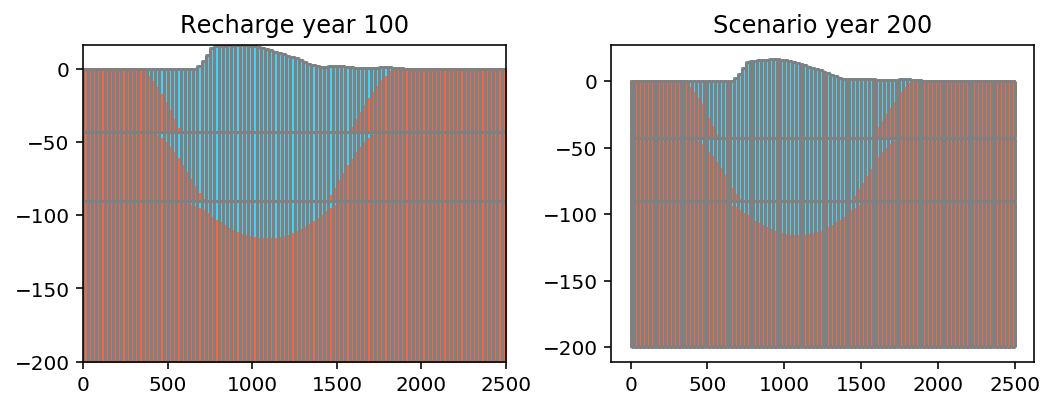

In [53]:
fig = plt.figure(figsize=(fwid, fhgt/2))
fig.subplots_adjust(wspace=0.25, hspace=0.25, left=flft, right=frgt, bottom=fbot, top=ftop)

colors = ['#40d3f7', '#F76541']

ax = fig.add_subplot(1, 2, 1)
modelxsect = flopy.plot.ModelCrossSection(model=ml, line={'Row': 50})
#, 
#                                          extent=(0, 3050, -50, -10))
modelxsect.plot_fill_between(zeta[3, :, :, :], colors=colors, ax=ax,
                              edgecolors='none')
linecollection = modelxsect.plot_grid(ax=ax)
ax.set_title('Recharge year {}'.format(years[4]));

ax = fig.add_subplot(1, 2, 2)
#ax.set_xlim(0, 3050)
#ax.set_ylim(-50, -10)
modelxsect.plot_fill_between(zeta[-1, :, :, :], colors=colors, ax=ax)
linecollection = modelxsect.plot_grid(ax=ax)
ax.set_title('Scenario year {}'.format(years[-1]));

In [54]:
#print(head)
np.max(head)

3.9979887

In [55]:
zeta.shape

(10, 3, 100, 100)

In [56]:
%pwd

'/home/sbhgeo/Documents/Fogland/Notebooks/FoglandPumping'